# This notebook is used to perform experiments with LIME
It holds all code that can be used to perform the LIME-related experiments on all models and the Jaccard-Index computations.

In [240]:
# imports
import os
import random
import torch

import matplotlib.pyplot as plt

from tqdm import tqdm
from torchvision import datasets, transforms
from data_utils.data_stats import *
from utils.metrics import AverageMeter, topk_acc
from torchmetrics import Accuracy
from models.resnet import resnet18
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm
from models.networks import get_model
from typing import Optional
from sklearn.metrics import jaccard_score

from skimage.measure import label
from skimage.color import label2rgb
import timm

from datasets import load_dataset

import cv2
from PIL import Image

In [241]:
# Hyperparameters
DATASET_NAME = "cifar10"  # one of: cifar10, tinyimagenet
DEVICE = "cpu"  # one of: cpu, cuda:0
BATCH_SIZE = 256

In [242]:
if DATASET_NAME == "cifar10":
    # CIFAR10 Dataset Configuration
    dataset_classes = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]
    dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

    # Setup dataloader
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=0)
    input_size = 32
elif DATASET_NAME == "tinyimagenet":
    # TinyImageNet Dataset Configuration
    dataset_classes = ['goldfish, Carassius auratus', 'European fire salamander, Salamandra salamandra', 'bullfrog, Rana catesbeiana', 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui', 'American alligator, Alligator mississipiensis', 'boa constrictor, Constrictor constrictor', 'trilobite', 'scorpion', 'black widow, Latrodectus mactans', 'tarantula', 'centipede', 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus', 'jellyfish', 'brain coral', 'snail', 'sea slug, nudibranch', 'American lobster, Northern lobster, Maine lobster, Homarus americanus', 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish', 'black stork, Ciconia nigra', 'king penguin, Aptenodytes patagonica', 'albatross, mollymawk', 'dugong, Dugong dugon', 'Yorkshire terrier', 'golden retriever', 'Labrador retriever', 'German shepherd, German shepherd dog, German police dog, alsatian', 'standard poodle', 'tabby, tabby cat', 'Persian cat', 'Egyptian cat', 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', 'lion, king of beasts, Panthera leo', 'brown bear, bruin, Ursus arctos', 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle', 'grasshopper, hopper', 'walking stick, walkingstick, stick insect', 'cockroach, roach', 'mantis, mantid', "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk", 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus', 'sulphur butterfly, sulfur butterfly', 'sea cucumber, holothurian', 'guinea pig, Cavia cobaya', 'hog, pig, grunter, squealer, Sus scrofa', 'ox', 'bison', 'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis', 'gazelle', 'Arabian camel, dromedary, Camelus dromedarius', 'orangutan, orang, orangutang, Pongo pygmaeus', 'chimpanzee, chimp, Pan troglodytes', 'baboon', 'African elephant, Loxodonta africana', 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens', 'abacus', "academic gown, academic robe, judge's robe", 'altar', 'backpack, back pack, knapsack, packsack, rucksack, haversack', 'bannister, banister, balustrade, balusters, handrail', 'barbershop', 'barn', 'barrel, cask', 'basketball', 'bathtub, bathing tub, bath, tub', 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon', 'beacon, lighthouse, beacon light, pharos', 'beaker', 'beer bottle', 'bikini, two-piece', 'binoculars, field glasses, opera glasses', 'birdhouse', 'bow tie, bow-tie, bowtie', 'brass, memorial tablet, plaque', 'bucket, pail', 'bullet train, bullet', 'butcher shop, meat market', 'candle, taper, wax light', 'cannon', 'cardigan', 'cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM', 'CD player', 'chest', 'Christmas stocking', 'cliff dwelling', 'computer keyboard, keypad', 'confectionery, confectionary, candy store', 'convertible', 'crane', 'dam, dike, dyke', 'desk', 'dining table, board', 'dumbbell', 'flagpole, flagstaff', 'fly', 'fountain', 'freight car', 'frying pan, frypan, skillet', 'fur coat', 'gasmask, respirator, gas helmet', 'go-kart', 'gondola', 'hourglass', 'iPod', 'jinrikisha, ricksha, rickshaw', 'kimono', 'lampshade, lamp shade', 'lawn mower, mower', 'lifeboat', 'limousine, limo', 'magnetic compass', 'maypole', 'military uniform', 'miniskirt, mini', 'moving van', 'neck brace', 'obelisk', 'oboe, hautboy, hautbois', 'organ, pipe organ', 'parking meter', 'pay-phone, pay-station', 'picket fence, paling', 'pill bottle', "plunger, plumber's helper", 'police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria', 'poncho', 'pop bottle, soda bottle', "potter's wheel", 'projectile, missile', 'punching bag, punch bag, punching ball, punchball', 'refrigerator, icebox', 'remote control, remote', 'rocking chair, rocker', 'rugby ball', 'sandal', 'school bus', 'scoreboard', 'sewing machine', 'snorkel', 'sock', 'sombrero', 'space heater', "spider web, spider's web", 'sports car, sport car', 'steel arch bridge', 'stopwatch, stop watch', 'sunglasses, dark glasses, shades', 'suspension bridge', 'swimming trunks, bathing trunks', 'syringe', 'teapot', 'teddy, teddy bear', 'thatch, thatched roof', 'torch', 'tractor', 'triumphal arch', 'trolleybus, trolley coach, trackless trolley', 'turnstile', 'umbrella', 'vestment', 'viaduct', 'volleyball', 'water jug', 'water tower', 'wok', 'wooden spoon', 'comic book', 'reel', 'guacamole', 'ice cream, icecream', 'ice lolly, lolly, lollipop, popsicle', 'goose', 'drumstick', 'plate', 'pretzel', 'mashed potato', 'cauliflower', 'bell pepper', 'lemon', 'banana', 'pomegranate', 'meat loaf, meatloaf', 'pizza, pizza pie', 'potpie', 'espresso', 'bee', 'apron', 'pole', 'Chihuahua', 'alp', 'cliff, drop, drop-off', 'coral reef', 'lakeside, lakeshore', 'seashore, coast, seacoast, sea-coast', 'acorn', 'broom', 'mushroom', 'nail', 'chain', 'slug', 'orange']
    dataset = load_dataset('Maysee/tiny-imagenet', split='valid')

    transform_test = transforms.ToTensor()

    def collate_fn_test(batch):
        return ((torch.stack([transform_test(Image.fromarray(cv2.cvtColor(np.array(x['image']),cv2.COLOR_GRAY2RGB))) if np.array(x['image']).ndim == 2 else transform_test(x['image']) for x in batch])), torch.tensor([x['label'] for x in batch]))

    data_loader = torch.utils.data.DataLoader(dataset, 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True, 
                                              num_workers=0, 
                                              collate_fn=collate_fn_test)
    input_size = 64
else:
    raise ValueError("Dataset is not registered!")

num_classes = CLASS_DICT[DATASET_NAME]
assert len(dataset_classes) == num_classes

mean = MEAN_DICT[DATASET_NAME]
std = STD_DICT[DATASET_NAME]

input_transform = transforms.Normalize(mean / 255., std / 255.)

torch.backends.cuda.matmul.allow_tf32 = True

Files already downloaded and verified


In [243]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model, input_size):
        super(ModelWrapper, self).__init__()
        self.model = model
        self.resize = transforms.Resize(input_size)

    def forward(self, x):
        x = self.resize(x)
        x = self.model(x)
        return x

class MLPWrapper(torch.nn.Module):
    def __init__(self, model, input_size):
        super(MLPWrapper, self).__init__()
        self.model = model
        self.resize = transforms.Resize(input_size)

    def forward(self, x):
        x = self.resize(x)
        x = x.flatten(1)
        x = self.model(x)
        return x

if not os.path.exists("checkpoints"):
        os.mkdir("checkpoints")

In [244]:
if DATASET_NAME == "cifar10":
    resnet_model = resnet18(pretrained=True)
    
    mlp_architecture = 'B_12-Wi_1024'  # B_12-Wi_512
    mlp_resolution = 64  # Resolution of fine-tuned model (64 for all models we provide)
    mlp_checkpoint = 'in21k_cifar10'  # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10
    mlp_model = get_model(architecture=mlp_architecture, resolution=mlp_resolution, num_classes=num_classes,
                          checkpoint=mlp_checkpoint)
    mlp_model = MLPWrapper(mlp_model, mlp_resolution)
    
    vit_path = "./models/ViT_cifar10.pt"
    vit_checkpoint = torch.load(vit_path, map_location=torch.device(DEVICE))
    vit_model = timm.create_model("vit_tiny_patch16_224", pretrained=True)
    vit_model.head = torch.nn.Linear(vit_model.head.in_features, num_classes)
    vit_model = torch.nn.DataParallel(vit_model) # make parallel
    vit_model.load_state_dict(vit_checkpoint['model'])

    vit_model = ModelWrapper(vit_model, 224)
elif DATASET_NAME == "tinyimagenet":
    resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, 200)

    resnet_path = "./models/resnet18_tinyimagenet.pt"
    resnet_checkpoint = torch.load(resnet_path, map_location=torch.device(DEVICE))

    resnet_model = torch.nn.DataParallel(resnet_model)
    resnet_model.load_state_dict(resnet_checkpoint['model'])

    resnet_model = ModelWrapper(resnet_model, 224)
    
    mlp_architecture = 'B_12-Wi_1024'
    mlp_resolution = 64
    checkpoint = 'in21k_imagenet'

    mlp_model = get_model(architecture=mlp_architecture, resolution=mlp_resolution, num_classes=1000, checkpoint=checkpoint)
    mlp_model.linear_out = torch.nn.Linear(1024, num_classes)

    mlp_path = "./models/mlp_tinyimagenet.pt"
    mlp_checkpoint = torch.load(mlp_path, map_location=torch.device(DEVICE))

    mlp_model = torch.nn.DataParallel(mlp_model)
    mlp_model.load_state_dict(mlp_checkpoint['model'])
    mlp_model = MLPWrapper(mlp_model, mlp_resolution)
    
    vit_path = "./models/ViT_tinyimagenet.pt"
    vit_checkpoint = torch.load(vit_path, map_location=torch.device(DEVICE))

    vit_model = timm.create_model("vit_tiny_patch16_224", pretrained=True)
    vit_model.head = torch.nn.Linear(vit_model.head.in_features, num_classes)
    vit_model = torch.nn.DataParallel(vit_model) # make parallel
    vit_model.load_state_dict(vit_checkpoint['model'])

    vit_model = ModelWrapper(vit_model, 224)
else:
    raise ValueError("Unknown dataset.")

models = {"CNN": resnet_model, "MLP": mlp_model, "VIT": vit_model}

Weights already downloaded
Load_state output <All keys matched successfully>


In [149]:
for name, model in models.items():
    model.eval()
    total_acc = AverageMeter()
    accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    with torch.no_grad():
        for ims, targs in tqdm(data_loader, desc=f"{DATASET_NAME} Evaluation {name}"):
            preds = model(input_transform(ims))
            acc, _ = topk_acc(preds, targs, k=1, avg=True)
            total_acc.update(acc, ims.shape[0])

    print(f"Model {name} Accuracy: %2.2f %%" % total_acc.get_avg(percentage=True))

tinyimagenet Evaluation CNN: 100%|██████████| 40/40 [09:35<00:00, 14.39s/it]


Model CNN Accuracy: 69.67 %


tinyimagenet Evaluation MLP: 100%|██████████| 40/40 [00:36<00:00,  1.09it/s]


Model MLP Accuracy: 72.52 %


tinyimagenet Evaluation VIT: 100%|██████████| 40/40 [09:33<00:00, 14.34s/it]

Model VIT Accuracy: 73.21 %


In [76]:
# Get the amount of missclassification per model and class.
# This enables us to inspect samples of classes that are hard to classify for a particular model.
missclassification_dict = {}

for name, model in models.items():
    missclassifcations = np.zeros(num_classes, dtype=int)
    model.eval()

    with torch.no_grad():
        for ims, targs in tqdm(data_loader, desc=f"Evaluation {name}"):
            preds = model(input_transform(ims))
            predicted_class = torch.argmax(preds, dim=-1)
            correct = predicted_class == targs
            wrong_classes = targs[~correct]
            for val in wrong_classes:
                missclassifcations[val.item()] += 1
    missclassification_dict[name] = missclassifcations
print(missclassification_dict)

Evaluation CNN: 100%|██████████| 40/40 [02:13<00:00,  3.33s/it]


CNN
[ 59  38  87 154  56 116  57  45  37  44]


Evaluation MLP: 100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


MLP
[ 38  54  52 132  39 118  41  48  34  35]


Evaluation VIT: 100%|██████████| 40/40 [09:46<00:00, 14.66s/it]

VIT
[31 14 42 81 28 47 10 34 13 26]


Can choose one of the following sample generator functions.

`get_random_images(max_samples: int)`: returns one example per class for *max_samples* classes

`get_sample_images(target_class: Optional[int], max_samples: int, model_verifiers: list[(str, bool)])`: see docstring below

In [245]:
# returns a list of class representatives for at most max_samples classes
def get_random_images(max_samples: int):
    random_samples = torch.empty((num_classes, 3, input_size, input_size))
    classes_seen = np.zeros(num_classes, dtype=bool)
    
    random_indices = random.sample(range(num_classes), max_samples) if num_classes > max_samples else range(num_classes)

    for i, (img, targs) in enumerate(data_loader):
        num_samples = img.shape[0]
        for j in range(num_samples):
            image, label = img[j], targs[j]
            if not classes_seen[label]:
                classes_seen[label] = True
                random_samples[label] = image
                if np.all(classes_seen[random_indices]):
                    return random_samples[random_indices], random_indices
    return random_samples[random_indices], random_indices

# get random samples from the dataset
# target_class: samples from which class should be selected (None, for no particular)
# max_samples: max amount of samples
# model_verifiers: list of (model name, bool)-pairs indicating for which model the prediction should be correct (True) or incorrect (False)
# example: get_sample_images(4, 10, [("MLP", True), ("CNN", False)])
#          selects at most 10 random samples of class 4 (= 'cat' for CIFAR10) for which "MLP" predicts correctly
#          and CNN predicts wrongly.
def get_sample_images(target_class: Optional[int], max_samples: int, model_verifiers: list[(str, bool)]):
    random_sample_images = []
    random_sample_labels = []
    
    for name, _ in model_verifiers:
        models[name].eval()
        
    with torch.no_grad():
        for ims, targs in data_loader:
            found_samples = None
            for name, find_correct in model_verifiers:
                preds = models[name](input_transform(ims))
                predicted_class = torch.argmax(preds, dim=-1)
                found_samples_mask = (predicted_class == targs) if find_correct else (predicted_class != targs)
                if target_class is not None:
                    found_samples_mask = (targs == target_class) & found_samples_mask
                if found_samples is None:
                    found_samples = found_samples_mask
                else:
                    found_samples = found_samples & found_samples_mask
            images = ims[found_samples]
            labels = targs[found_samples]
            for i in range(len(images)):
                random_sample_images.append(images[i])
                random_sample_labels.append(labels[i])
                if len(random_sample_images) >= max_samples:
                    return torch.stack(random_sample_images), torch.stack(random_sample_labels)
    return torch.stack(random_sample_images), torch.stack(random_sample_labels)

# reshape to get input tensor for a particular image
def get_input_tensor(img):
    img = input_transform(img).unsqueeze(0)
    return img

Select the images, on which to perform LIME and visualize them.

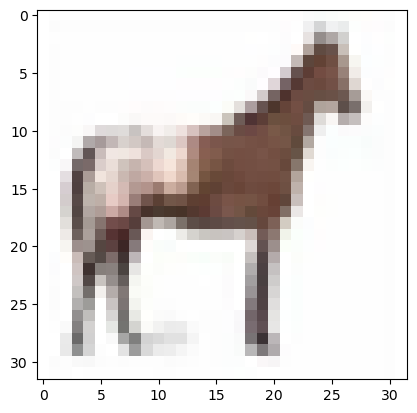

Image with true label horse (7)


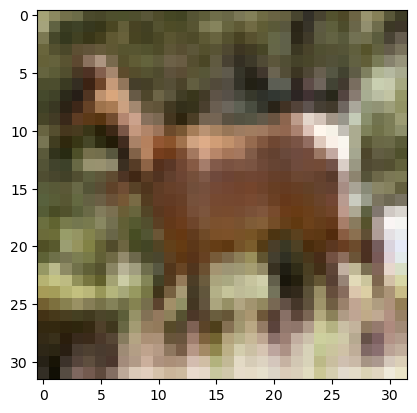

Image with true label deer (4)


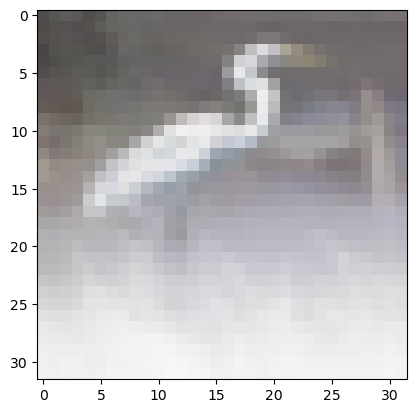

Image with true label bird (2)


In [272]:
images, labels = get_sample_images(None, 3, [("MLP", True), ("CNN", True), ("VIT", True)])

for image, label in zip(images, labels):
    image_np = image.numpy().transpose((1, 2, 0))
    plt.imshow(image_np)
    plt.show()
    print(f"Image with true label {dataset_classes[label]} ({label})")

Perform LIME on the generated samples for all models and visualize the results in a grid.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

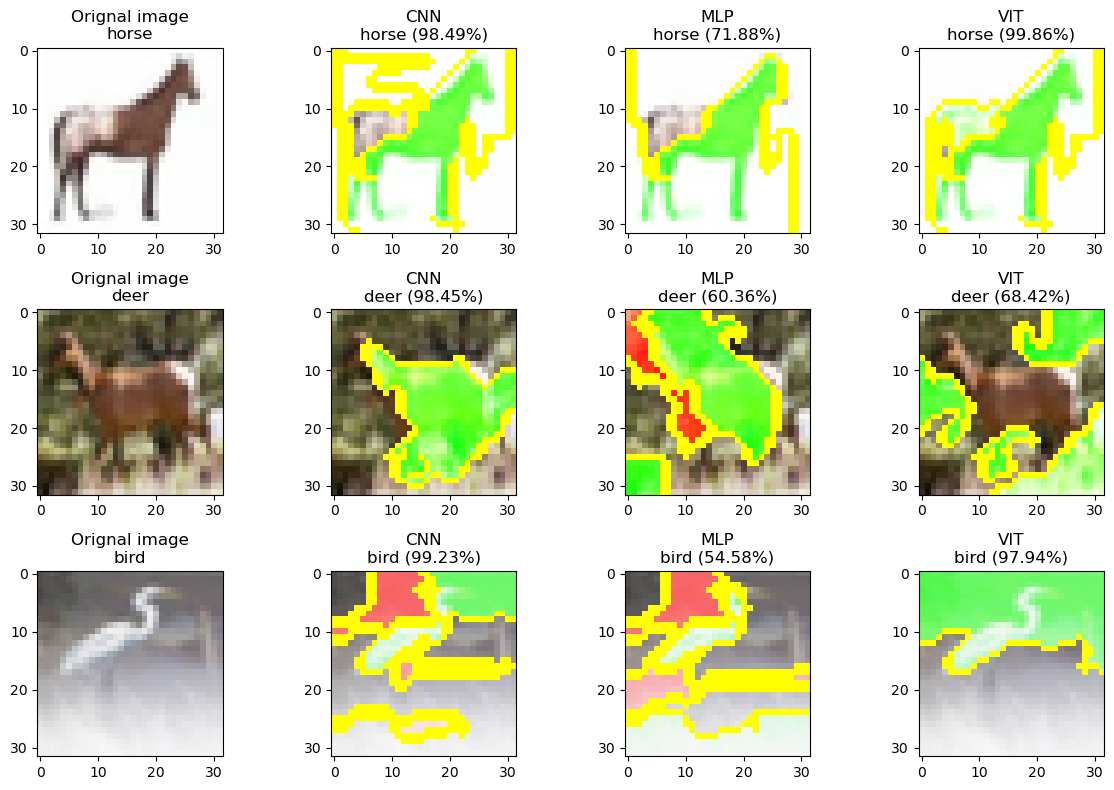

In [274]:

assert len(images) == len(labels)

lime_transform = transforms.Compose([
    transforms.ToTensor(),
    input_transform
])
num_lime_samples = 100 if DATASET_NAME == "cifar10" else 1000

segmentation_fn = SegmentationAlgorithm('felzenszwalb', scale=1, sigma=.8)

fig, axes = plt.subplots(len(images), len(models.keys()) + 1, figsize=(12, 8))
masks = {}
for name in models.keys():
    masks[name] = np.empty((len(images), input_size, input_size), dtype=bool)

for index, (image, label) in enumerate(zip(images, labels)):
    image_np = image.numpy().transpose((1, 2, 0))
    axes[index][0].imshow(images[index].numpy().transpose((1, 2, 0)))
    axes[index][0].set_title(f"Orignal image\n{dataset_classes[label]}")
    # axes[index][0].axis('off')  # to export
    
    for model_idx, (name, model) in enumerate(models.items()):
        model.eval()
        
        def batch_predict(images):
            batch = torch.stack([lime_transform(i) for i in images])

            with torch.no_grad():
                logits = model(batch)
                probs = torch.nn.functional.softmax(logits, dim=-1).numpy()
                return probs
        
        with torch.no_grad():
            explainer = lime_image.LimeImageExplainer()
            explanation = explainer.explain_instance(image_np, 
                                                     batch_predict, # classification function
                                                     top_labels=1, 
                                                     hide_color=0,
                                                     segmentation_fn=segmentation_fn,
                                                     num_samples=num_lime_samples) # number of images that will be sent to classification
            
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
            
            masks[name][index] = mask == 1
            
            img_boundry = mark_boundaries(temp, mask)
            axes[index][model_idx + 1].imshow(img_boundry)
            
            output = model(get_input_tensor(image))
            probabilities = torch.nn.functional.softmax(output, dim=-1).squeeze()
            predicted_class = torch.argmax(probabilities).item()

            predicted_label = dataset_classes[predicted_class]
            
            axes[index][model_idx + 1].set_title(f"{name}\n{predicted_label} ({(probabilities[predicted_class] * 100):.2f}%)")
            # axes[index][model_idx + 1].axis('off')  # to export

plt.tight_layout()
plt.show()

Compare the models using the **Jaccard Index**, which is a similarity measure between two sets. There is no visualization done. Attention: for TinyImageNet, the execution takes a while. Rather perform it on CIFAR10.

In [275]:
def jaccard(mask1, mask2):
    if mask1.shape != mask2.shape:
        raise ValueError("Shape mismatch: mask1 and mask2 must have the same shape.")

    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)

    return intersection.sum() / float(union.sum())

In [263]:
images, labels = get_sample_images(None, 100, [("MLP", True), ("CNN", True), ("VIT", True)])

lime_transform = transforms.Compose([
    transforms.ToTensor(),
    input_transform
])
num_lime_samples = 100 if DATASET_NAME == "cifar10" else 1000

segmentation_fn = SegmentationAlgorithm('felzenszwalb', scale=1, sigma=.8)

masks = {}
for name in models.keys():
    masks[name] = np.empty((len(images), input_size, input_size), dtype=bool)

for index, (image, label) in enumerate(zip(images, labels)):
    image_np = image.numpy().transpose((1, 2, 0))    
    for model_idx, (name, model) in enumerate(models.items()):
        model.eval()
        
        def batch_predict(images):
            batch = torch.stack([lime_transform(i) for i in images])

            with torch.no_grad():
                logits = model(batch)
                probs = torch.nn.functional.softmax(logits, dim=-1).numpy()
                return probs
        
        with torch.no_grad():
            explainer = lime_image.LimeImageExplainer()
            explanation = explainer.explain_instance(image_np, 
                                                     batch_predict, # classification function
                                                     top_labels=1, 
                                                     hide_color=0,
                                                     segmentation_fn=segmentation_fn,
                                                     num_samples=num_lime_samples) # number of images that will be sent to classification
            
            _, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
            
            masks[name][index] = mask == 1

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:05<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [265]:
jaccard_matrix = np.empty((len(models.keys()), len(models.keys())))

used_models = ["CNN", "MLP", "VIT"]

for model1_idx, name1 in enumerate(used_models):
    for model2_idx, name2 in enumerate(used_models):
        jaccard_arr = np.empty(len(images))
        for i in range(len(images)):
            jaccard_arr[i] = jaccard(masks[name1][i], masks[name2][i])
        jaccard_matrix[model1_idx][model2_idx] = np.mean(jaccard_arr)

# output the different Jaccard-Indices.
print(f"Models used: {used_models}")
print("Jaccard Matrix:")
print(jaccard_matrix)
print(f"Number of images used: {len(images)}")

Models used: ['CNN', 'MLP', 'VIT']
Jaccard Matrix:
[[1.         0.38969455 0.38887909]
 [0.38969455 1.         0.39768633]
 [0.38887909 0.39768633 1.        ]]
Number of images used: 100
